In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
from functools import reduce

# warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

# Hide warning temporarily
pd.options.mode.chained_assignment = None

In [24]:
df = pd.read_csv("data/flights_sample_2m.csv")

### PREPARATION

In [31]:
dow_category = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                            "Saturday", "Sunday"], ordered=True)

df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
df["YEAR"] = df["FL_DATE"].dt.year
df["MONTH"] = df["FL_DATE"].dt.month
df["QUARTER"] = ((df["MONTH"] -1)//3)+1
#df["DAY_OF_WEEK"] = df["FL_DATE"].dt.dayofweek.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
#                                                     4: 'Friday', 5: 'Saturday', 6: 'Sunday'}).astype(dow_category)
df["DAY_OF_WEEK"] = df["FL_DATE"].dt.dayofweek.map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

df["DISTANCE_CAT"] = pd.cut(
    df["DISTANCE"], bins = [-1, 500, 1500, float("inf")],
    labels = ["Short-haul", "Medium-haul", "Long-haul"])

df["DEP_HOUR"] = (df["CRS_DEP_TIME"] // 100).astype(int)

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["SEASON"] = df["MONTH"].apply(get_season)

df['YEAR_MONTH'] = pd.to_datetime(df['FL_DATE']).dt.to_period("M")


### OVERVIEW DATASET

In [26]:
# Number of flights delayed
n_flight_delay = (df['ARR_DELAY'] > 15).sum()
n_flight_ontime = (df['ARR_DELAY'] <= 15).sum()

n_flight_cancel = (df['CANCELLED'] == 1).sum()
n_flight_divert = (df['DIVERTED'] == 1).sum()

n_flights = len(df)

lst_airline = sorted(df['AIRLINE'].unique())
n_airlines = len(lst_airline)

n_short_distance = (df["DISTANCE_CAT"] == 'Short-haul').sum()
n_medium_distance = (df["DISTANCE_CAT"] == 'Medium-haul').sum()
n_long_distance = (df["DISTANCE_CAT"] == 'Long-haul').sum()

print(f"=====Overall Dataset=====")
print(f"Total flights: {n_flights:,}")
print(f"Total airlines: {n_airlines}")
print(f"There are {n_flight_delay:,} flights delayed")
print(f"There are {n_flight_cancel:,} flights cancelled")
print(f"There are {n_flight_divert:,} flights diverted")
print(f"There are {n_flight_ontime:,} on-time flights")
print(f"There are {n_short_distance:,} short-haul flights")
print(f"There are {n_medium_distance:,} medium-haul flights")
print(f"There are {n_long_distance:,} long-haul flights")

=====Overall Dataset=====
Total flights: 2,000,000
Total airlines: 18
There are 343,875 flights delayed
There are 52,522 flights cancelled
There are 4,709 flights diverted
There are 1,598,894 on-time flights
There are 728,353 short-haul flights
There are 1,030,907 medium-haul flights
There are 240,740 long-haul flights


In [32]:
type(df['YEAR_MONTH'])

pandas.core.series.Series

In [33]:
df_flights = df.copy()

In [7]:
# Route phổ biến nhất (ORIGIN → DEST)
df_flights['ROUTE'] = df_flights['ORIGIN_CITY'] + " → " + df_flights['DEST_CITY']
top_routes = (
    df_flights.groupby("ROUTE")["FL_DATE"]
    .count()
    .reset_index(name="Total_Flights")
    .sort_values("Total_Flights", ascending=False)
    .head(10)
)
top_routes

,ROUTE,Total_Flights
1268,"Chicago, IL → New York, NY",4495
4363,"New York, NY → Chicago, IL",4462
4353,"New York, NY → Boston, MA",3887
740,"Boston, MA → New York, NY",3706
5924,"San Francisco, CA → Los Angeles, CA",3650
3615,"Los Angeles, CA → San Francisco, CA",3491
315,"Atlanta, GA → New York, NY",3346
4345,"New York, NY → Atlanta, GA",3268
6899,"Washington, DC → Chicago, IL",3091
3359,"Las Vegas, NV → Los Angeles, CA",3089


In [8]:
df_flights['AIRPORT'] = df_flights['ORIGIN_CITY'] + " (" + df_flights['ORIGIN'] + ")"
top_busiest_airport = (
    df_flights.groupby("AIRPORT")["FL_DATE"]
    .count()
    .reset_index(name="Total_Flights")
    .sort_values("Total_Flights", ascending=False)
    .head(10)
)
top_busiest_airport

,AIRPORT,Total_Flights
19,"Atlanta, GA (ATL)",102727
85,"Dallas/Fort Worth, TX (DFW)",86669
66,"Chicago, IL (ORD)",82415
91,"Denver, CO (DEN)",79871
61,"Charlotte, NC (CLT)",63389
205,"Los Angeles, CA (LAX)",57020
272,"Phoenix, AZ (PHX)",50266
193,"Las Vegas, NV (LAS)",48754
324,"Seattle, WA (SEA)",47138
259,"Orlando, FL (MCO)",42946


In [6]:
df_clean = df_flights[df_flights['ARR_DELAY']>15]

# Tạo histogram
fig = px.histogram(
    df_clean, 
    x='ARR_DELAY', 
    #nbins=50,
    title='Distribution of Arrival Delays',
    labels={'ARR_DELAY':'Arrival Delay (minutes)'},
    color_discrete_sequence=['aquamarine']
)
fig.update_traces(marker_line_color='black', 
                  marker_line_width=0.7)

fig.update_xaxes(range=[-60, 180])
fig.update_yaxes(title='Number of Flights')

fig.update_layout(
    height=500, bargap=0, bargroupgap=0
)

fig.show()

In [12]:
def group_by_year(df, value_col, func, new_name):
    return (
        df.groupby("YEAR")[value_col]
          .apply(func)
          .reset_index(name=new_name))

In [8]:
def plot_yearly_flights_by_airline(df, airline_name):
    airline_df = df[df['AIRLINE'] == airline_name]

    # --- Tổng số flight mỗi năm ---
    airline_yearly = group_by_year(airline_df, "FL_DATE", "count", "Total_Flights")

    # --- Các số lượng điều kiện ---
    delayed_df = airline_df[airline_df['ARR_DELAY'] > 15]
    ontime_df = airline_df[airline_df['ARR_DELAY'] <= 15]
    cancel_df = airline_df[airline_df['CANCELLED'] == 1]
    divert_df = airline_df[airline_df['DIVERTED'] == 1]

    # --- Đếm theo năm ---
    delayed_yearly = group_by_year(delayed_df, "FL_DATE", "count", "Delayed_Flights")
    ontime_yearly  = group_by_year(ontime_df, "FL_DATE", "count", "OnTime_Flights")
    cancel_yearly  = group_by_year(cancel_df, "FL_DATE", "count", "Cancelled_Flights")
    divert_yearly  = group_by_year(divert_df, "FL_DATE", "count", "Diverted_Flights")

    # --- Gộp tất cả ---
    dfs = [airline_yearly, delayed_yearly, ontime_yearly, cancel_yearly, divert_yearly]

    final_df = reduce(lambda l, r: l.merge(r, on="YEAR", how="left"), dfs)
    final_df = final_df.fillna(0)

    # --- Tính tỷ lệ ---
    final_df["Arrival_Delay_Rate"] = (final_df["Delayed_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["OnTime_Rate"] = (final_df["OnTime_Flights"]  / final_df["Total_Flights"] * 100).round(2)
    final_df["Cancel_Rate"] = (final_df["Cancelled_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["Divert_Rate"] = (final_df["Diverted_Flights"]  / final_df["Total_Flights"] * 100).round(2)

    # --- Plot ---
    fig = px.bar(airline_yearly,
                x="YEAR", y="Total_Flights",
                title=f"Total number of flights of {airline_name} per year (2019–2023)",
                color="YEAR", height=450)
    fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
    fig.show()

    return final_df

In [9]:
plot_yearly_flights_by_airline(df_flights, "Envoy Air")

,YEAR,Total_Flights,Delayed_Flights,OnTime_Flights,Cancelled_Flights,Diverted_Flights,Arrival_Delay_Rate,OnTime_Rate,Cancel_Rate,Divert_Rate
0,2019,22111,4259,17000,788,64,19.26,76.88,3.56,0.29
1,2020,14435,1694,11921,799,21,11.74,82.58,5.54,0.15
2,2021,17665,2611,14584,423,47,14.78,82.56,2.39,0.27
3,2022,16823,2756,13618,406,43,16.38,80.95,2.41,0.26
4,2023,10111,1853,8087,146,25,18.33,79.98,1.44,0.25


In [10]:
def group_by_quarter(df, value_col, func, new_name):
    return (
        df.groupby(["YEAR","QUARTER"])[value_col]
          .apply(func)
          .reset_index(name=new_name))

In [11]:
def plot_quarter_flights_by_airline(df, airline_name):
    airline_df = df[df['AIRLINE'] == airline_name]

    # --- Tổng số flight mỗi năm ---
    airline_quarter = group_by_quarter(airline_df, "FL_DATE", "count", "Total_Flights")

    # --- Các số lượng điều kiện ---
    delayed_df = airline_df[airline_df['ARR_DELAY'] > 15]
    ontime_df = airline_df[airline_df['ARR_DELAY'] <= 15]
    cancel_df = airline_df[airline_df['CANCELLED'] == 1]
    divert_df = airline_df[airline_df['DIVERTED'] == 1]

    # --- Đếm theo năm ---
    delayed_quarter = group_by_quarter(delayed_df, "FL_DATE", "count", "Delayed_Flights")
    ontime_quarter  = group_by_quarter(ontime_df, "FL_DATE", "count", "OnTime_Flights")
    cancel_quarter  = group_by_quarter(cancel_df, "FL_DATE", "count", "Cancelled_Flights")
    divert_quarter  = group_by_quarter(divert_df, "FL_DATE", "count", "Diverted_Flights")

    # --- Gộp tất cả ---
    dfs = [airline_quarter, delayed_quarter, ontime_quarter, cancel_quarter, divert_quarter]

    final_df = reduce(lambda l, r: l.merge(r, on=["YEAR", "QUARTER"], how="left"), dfs)
    final_df = final_df.fillna(0)

    # --- Tính tỷ lệ ---
    final_df["Arrival_Delay_Rate"] = (final_df["Delayed_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["OnTime_Rate"] = (final_df["OnTime_Flights"]  / final_df["Total_Flights"] * 100).round(2)
    final_df["Cancel_Rate"] = (final_df["Cancelled_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["Divert_Rate"] = (final_df["Diverted_Flights"]  / final_df["Total_Flights"] * 100).round(2)

    # --- Plot ---
    fig = px.line(airline_quarter,
                  x='QUARTER', y='Total_Flights',
                  color = 'YEAR',
                  title = f'Quarterly Flights Trend of {airline_name} (2019-2023)',
                  height = 450, markers=True)
    fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
    fig.show()

    return final_df

In [12]:
plot_quarter_flights_by_airline(df_flights, "Envoy Air")

,YEAR,QUARTER,Total_Flights,Delayed_Flights,OnTime_Flights,Cancelled_Flights,Diverted_Flights,Arrival_Delay_Rate,OnTime_Rate,Cancel_Rate,Divert_Rate
0,2019,1,5067,1031,3768,259,9,20.35,74.36,5.11,0.18
1,2019,2,5617,1198,4181,219,19,21.33,74.43,3.90,0.34
2,2019,3,5982,1115,4621,225,21,18.64,77.25,3.76,0.35
3,2019,4,5445,915,4430,85,15,16.80,81.36,1.56,0.28
4,2020,1,5280,751,4173,348,8,14.22,79.03,6.59,0.15
5,2020,2,2477,131,1932,412,2,5.29,78.00,16.63,0.08
6,2020,3,3368,358,2987,17,6,10.63,88.69,0.50,0.18
7,2020,4,3310,454,2829,22,5,13.72,85.47,0.66,0.15
8,2021,1,3759,518,3039,192,10,13.78,80.85,5.11,0.27
9,2021,2,4439,738,3608,75,18,16.63,81.28,1.69,0.41


In [13]:
def group_by_monthly(df, value_col, func, new_name):
    return (
        df.groupby(["YEAR","MONTH"])[value_col]
          .apply(func)
          .reset_index(name=new_name))

In [14]:
def plot_monthly_flights_by_airline(df, airline_name):
    airline_df = df[df['AIRLINE'] == airline_name]

    # --- Tổng số flight mỗi năm ---
    airline_monthly = group_by_monthly(airline_df, "FL_DATE", "count", "Total_Flights")

    # --- Các số lượng điều kiện ---
    delayed_df = airline_df[airline_df['ARR_DELAY'] > 15]
    ontime_df = airline_df[airline_df['ARR_DELAY'] <= 15]
    cancel_df = airline_df[airline_df['CANCELLED'] == 1]
    divert_df = airline_df[airline_df['DIVERTED'] == 1]

    # --- Đếm theo năm ---
    delayed_monthly = group_by_monthly(delayed_df, "FL_DATE", "count", "Delayed_Flights")
    ontime_monthly  = group_by_monthly(ontime_df, "FL_DATE", "count", "OnTime_Flights")
    cancel_monthly  = group_by_monthly(cancel_df, "FL_DATE", "count", "Cancelled_Flights")
    divert_monthly  = group_by_monthly(divert_df, "FL_DATE", "count", "Diverted_Flights")

    # --- Gộp tất cả ---
    dfs = [airline_monthly, delayed_monthly, ontime_monthly, cancel_monthly, divert_monthly]

    final_df = reduce(lambda l, r: l.merge(r, on=["YEAR", "MONTH"], how="left"), dfs)
    final_df = final_df.fillna(0)

    # --- Tính tỷ lệ ---
    final_df["Arrival_Delay_Rate"] = (final_df["Delayed_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["OnTime_Rate"] = (final_df["OnTime_Flights"]  / final_df["Total_Flights"] * 100).round(2)
    final_df["Cancel_Rate"] = (final_df["Cancelled_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["Divert_Rate"] = (final_df["Diverted_Flights"]  / final_df["Total_Flights"] * 100).round(2)

    # --- Plot ---
    fig = px.line(airline_monthly,
                  x='MONTH', y='Total_Flights',
                  color='YEAR',
                  title=f'Monthly Flights Trend of {airline_name} (2019-2023)',
                  height=400, markers=True)
    fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
    fig.show()

    return final_df

In [15]:
plot_monthly_flights_by_airline(df_flights, "Envoy Air")

,YEAR,MONTH,Total_Flights,Delayed_Flights,OnTime_Flights,Cancelled_Flights,Diverted_Flights,Arrival_Delay_Rate,OnTime_Rate,Cancel_Rate,Divert_Rate
0,2019,1,1751,352,1259,139.0,1.0,20.10,71.90,7.94,0.06
1,2019,2,1531,409,1023,93.0,6.0,26.71,66.82,6.07,0.39
2,2019,3,1785,270,1486,27.0,2.0,15.13,83.25,1.51,0.11
3,2019,4,1761,272,1413,71.0,5.0,15.45,80.24,4.03,0.28
4,2019,5,1933,437,1430,63.0,3.0,22.61,73.98,3.26,0.16
5,2019,6,1923,489,1338,85.0,11.0,25.43,69.58,4.42,0.57
6,2019,7,1999,392,1504,97.0,6.0,19.61,75.24,4.85,0.30
7,2019,8,2106,410,1616,69.0,11.0,19.47,76.73,3.28,0.52
8,2019,9,1877,313,1501,59.0,4.0,16.68,79.97,3.14,0.21
9,2019,10,1875,331,1512,28.0,4.0,17.65,80.64,1.49,0.21


In [16]:
def group_by_dow(df, value_col, func, new_name):
    return (
        df.groupby(["YEAR","DAY_OF_WEEK"])[value_col]
          .apply(func)
          .reset_index(name=new_name))

In [17]:
def plot_weekly_flights_by_airline(df, airline_name):
    airline_df = df[df['AIRLINE'] == airline_name]

    # --- Tổng số flight mỗi năm ---
    airline_dow = group_by_dow(airline_df, "FL_DATE", "count", "Total_Flights")

    # --- Các số lượng điều kiện ---
    delayed_df = airline_df[airline_df['ARR_DELAY'] > 15]
    ontime_df = airline_df[airline_df['ARR_DELAY'] <= 15]
    cancel_df = airline_df[airline_df['CANCELLED'] == 1]
    divert_df = airline_df[airline_df['DIVERTED'] == 1]

    # --- Đếm theo năm ---
    delayed_dow = group_by_dow(delayed_df, "FL_DATE", "count", "Delayed_Flights")
    ontime_dow  = group_by_dow(ontime_df, "FL_DATE", "count", "OnTime_Flights")
    cancel_dow  = group_by_dow(cancel_df, "FL_DATE", "count", "Cancelled_Flights")
    divert_dow  = group_by_dow(divert_df, "FL_DATE", "count", "Diverted_Flights")

    # --- Gộp tất cả ---
    dfs = [airline_dow, delayed_dow, ontime_dow, cancel_dow, divert_dow]

    final_df = reduce(lambda l, r: l.merge(r, on=["YEAR", "DAY_OF_WEEK"], how="left"), dfs)
    final_df["DAY_OF_WEEK"] = final_df["DAY_OF_WEEK"].astype(dow_category)

    # --- Tính tỷ lệ ---
    final_df["Arrival_Delay_Rate"] = (final_df["Delayed_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["OnTime_Rate"] = (final_df["OnTime_Flights"]  / final_df["Total_Flights"] * 100).round(2)
    final_df["Cancel_Rate"] = (final_df["Cancelled_Flights"] / final_df["Total_Flights"] * 100).round(2)
    final_df["Divert_Rate"] = (final_df["Diverted_Flights"]  / final_df["Total_Flights"] * 100).round(2)

    # --- Plot ---
    fig = px.line(airline_dow,
                  x='DAY_OF_WEEK', y='Total_Flights',
                  color='YEAR',
                  title=f'Weekly Flights Trend of {airline_name} (2019-2023)',
                  height=400, markers=True)
    #fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
    fig.show()

    return final_df

In [18]:
plot_weekly_flights_by_airline(df_flights, "Envoy Air")

,YEAR,DAY_OF_WEEK,Total_Flights,Delayed_Flights,OnTime_Flights,Cancelled_Flights,Diverted_Flights,Arrival_Delay_Rate,OnTime_Rate,Cancel_Rate,Divert_Rate
0,2019,Friday,3258,668,2515,67,8.0,20.50,77.19,2.06,0.25
1,2019,Monday,3371,733,2478,154,6.0,21.74,73.51,4.57,0.18
2,2019,Saturday,2621,420,2118,72,11.0,16.02,80.81,2.75,0.42
3,2019,Sunday,3233,635,2442,144,12.0,19.64,75.53,4.45,0.37
4,2019,Thursday,3210,618,2461,125,6.0,19.25,76.67,3.89,0.19
5,2019,Tuesday,3212,597,2500,106,9.0,18.59,77.83,3.30,0.28
6,2019,Wednesday,3206,588,2486,120,12.0,18.34,77.54,3.74,0.37
7,2020,Friday,2144,247,1762,135,NaN,11.52,82.18,6.30,NaN
8,2020,Monday,2184,239,1830,113,2.0,10.94,83.79,5.17,0.09
9,2020,Saturday,1881,204,1573,101,3.0,10.85,83.63,5.37,0.16


In [19]:
def plot_delay_by_dep_hh(df, airline_name):
    airline_df = df[df['AIRLINE'] == airline_name]

    delay_avg_hourly = (
        airline_df.groupby(["YEAR", "DEP_HOUR"])["DEP_DELAY"]
        .mean().reset_index(name = "Avg_Departure_Delay").round(1))

    fig = px.bar(delay_avg_hourly,
                x="DEP_HOUR", y="Avg_Departure_Delay",
                title="Average Departure Delay by Departure Hour",
                color = "YEAR", height = 450)
    fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
    fig.show()

    return delay_avg_hourly

In [20]:
plot_delay_by_dep_hh(df_flights, "Envoy Air")

,YEAR,DEP_HOUR,Avg_Departure_Delay
0,2019,0,0.0
1,2019,1,-4.0
2,2019,5,1.2
3,2019,6,2.5
4,2019,7,5.5
...,...,...,...
89,2023,18,12.4
90,2023,19,13.8
91,2023,20,12.6
92,2023,21,5.9


In [21]:
def plot_delay_by_seasonal(df, airline_name):
    airline_df = df[df['AIRLINE'] == airline_name]

    delay_seasonal = (
        airline_df.groupby(["YEAR", "SEASON"])["DEP_DELAY"]
            .mean().reset_index(name = "Avg_Departure_Delay").round(1))

    # Pivot để heatmap dùng được
    pivot = delay_seasonal.pivot(index="SEASON", columns="YEAR", 
                                 values="Avg_Departure_Delay")

    fig = px.imshow(
        pivot,
        labels=dict(x="YEAR", y="SEASON", color="Avg Departure Delay (min)"),
        text_auto=".1f",
        color_continuous_scale="YlOrRd",
        aspect="auto"
    )
    
    fig.update_layout(
        title=f"Average Departure Delay by Season — {airline_name}",
        height=450
    )
    
    fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
    fig.show()

    return delay_seasonal

In [22]:
plot_delay_by_seasonal(df_flights, "Envoy Air")

,YEAR,SEASON,Avg_Departure_Delay
0,2019,Fall,5.6
1,2019,Spring,8.1
2,2019,Summer,10.6
3,2019,Winter,10.6
4,2020,Fall,0.5
5,2020,Spring,-2.2
6,2020,Summer,0.2
7,2020,Winter,5.6
8,2021,Fall,2.8
9,2021,Spring,4.4


In [23]:
def calc_delay_cancel_rate(df, group_col):
    result = df.groupby(group_col).agg(
        total_flights = ('FL_DATE', 'count'),
        delay_flights = ('DEP_DELAY', lambda x: (x > 0).sum()),
        cancelled_flights = ('CANCELLED', 'sum')
    )

    result['delay_rate'] = (result['delay_flights'] / result['total_flights'] * 100).round(3)
    result['cancel_rate'] = (result['cancelled_flights'] / result['total_flights'] * 100).round(3)

    return result.sort_values('delay_rate', ascending=False)

def print_top_delay_cancel(df, group_col, label):
    rates = calc_delay_cancel_rate(df, group_col)

    print(f"\n=== {label} có tỉ lệ DELAY cao nhất ===")
    display(rates.sort_values('delay_rate', ascending=False).head(5))

    print(f"\n=== {label} có tỉ lệ CANCEL cao nhất ===")
    display(rates.sort_values('cancel_rate', ascending=False).head(5))

In [24]:
airline_stats = print_top_delay_cancel(df, "AIRLINE", "Hãng bay")
airline_stats


=== Hãng bay có tỉ lệ DELAY cao nhất ===


,total_flights,delay_flights,cancelled_flights,delay_rate,cancel_rate
AIRLINE,,,,,
Southwest Airlines Co.,384493,177083,12800.0,46.056,3.329
JetBlue Airways,75129,30052,2113.0,40.001,2.812
Frontier Airlines Inc.,43012,16697,1160.0,38.819,2.697
Hawaiian Airlines Inc.,21418,7976,260.0,37.240,1.214
Allegiant Air,35175,12905,1644.0,36.688,4.674



=== Hãng bay có tỉ lệ CANCEL cao nhất ===


,total_flights,delay_flights,cancelled_flights,delay_rate,cancel_rate
AIRLINE,,,,,
ExpressJet Airlines LLC d/b/a aha!,12673,3099,690.0,24.454,5.445
Allegiant Air,35175,12905,1644.0,36.688,4.674
Mesa Airlines Inc.,43396,11803,1575.0,27.198,3.629
Southwest Airlines Co.,384493,177083,12800.0,46.056,3.329
Envoy Air,81145,20850,2562.0,25.695,3.157


In [25]:
airport_stats = print_top_delay_cancel(df, "ORIGIN", "Sân bay")
airport_stats


=== Sân bay có tỉ lệ DELAY cao nhất ===


,total_flights,delay_flights,cancelled_flights,delay_rate,cancel_rate
ORIGIN,,,,,
ILG,12,7,0.0,58.333,0.000
HTS,176,98,10.0,55.682,5.682
SCK,219,118,10.0,53.881,4.566
ADK,28,15,1.0,53.571,3.571
MDW,23131,11910,933.0,51.489,4.034



=== Sân bay có tỉ lệ CANCEL cao nhất ===


,total_flights,delay_flights,cancelled_flights,delay_rate,cancel_rate
ORIGIN,,,,,
MMH,68,20,20.0,29.412,29.412
CDB,21,10,4.0,47.619,19.048
ART,17,8,3.0,47.059,17.647
PGV,15,4,2.0,26.667,13.333
RIW,113,24,12.0,21.239,10.619


In [26]:
def analyze_flights_routes(df, group_col, group_value, top_n=5):
    # Lọc theo group_value
    df_sub = df[df[group_col] == group_value]

    # Chuyến bay đông nhất (FL_NUMBER)
    top_flights = (
        df_sub.groupby("FL_NUMBER")["FL_DATE"]
        .count()
        .reset_index(name="Total_Flights")
        .sort_values("Total_Flights", ascending=False)
        .head(top_n)
    )
    print(f"\n=== Top {top_n} chuyến bay đông nhất của {group_value} ({group_col}) ===")
    display(top_flights)

    # Route phổ biến nhất (ORIGIN → DEST)
    df_sub['ROUTE'] = df_sub['ORIGIN_CITY'] + " → " + df_sub['DEST_CITY']
    top_routes = (
        df_sub.groupby("ROUTE")["FL_DATE"]
        .count()
        .reset_index(name="Total_Flights")
        .sort_values("Total_Flights", ascending=False)
        .head(top_n)
    )
    print(f"\n=== Top {top_n} route phổ biến nhất của {group_value} ({group_col}) ===")
    display(top_routes)

    # Delay trung bình theo route
    delay_routes = (
        df_sub.groupby("ROUTE")["DEP_DELAY"]
        .mean()
        .reset_index(name="Avg_Departure_Delay")
        .sort_values("Avg_Departure_Delay", ascending=False)
        .head(top_n)
    )
    print(f"\n=== Top {top_n} route có delay trung bình cao nhất của {group_value} ({group_col}) ===")
    display(delay_routes)

In [28]:
analyze_flights_routes(df_flights, "AIRLINE", "SkyWest Airlines Inc.")


=== Top 5 chuyến bay đông nhất của SkyWest Airlines Inc. (AIRLINE) ===


,FL_NUMBER,Total_Flights
1975,5102,253
1977,5104,210
550,3501,206
717,3668,191
133,3084,188



=== Top 5 route phổ biến nhất của SkyWest Airlines Inc. (AIRLINE) ===


,ROUTE,Total_Flights
2030,"San Francisco, CA → Los Angeles, CA",1095
1349,"Los Angeles, CA → San Francisco, CA",1038
338,"Chicago, IL → Detroit, MI",858
814,"Detroit, MI → Chicago, IL",849
2145,"Seattle, WA → Boise, ID",798



=== Top 5 route có delay trung bình cao nhất của SkyWest Airlines Inc. (AIRLINE) ===


,ROUTE,Avg_Departure_Delay
2298,"Twin Falls, ID → San Francisco, CA",1091.000000
901,"Eagle, CO → Salt Lake City, UT",1013.000000
1868,"Rochester, MN → Atlanta, GA",467.000000
1218,"Kansas City, MO → Austin, TX",370.666667
1878,"Rock Springs, WY → Riverton/Lander, WY",209.000000


In [29]:
analyze_flights_routes(df_flights, "ORIGIN", "JFK")


=== Top 5 chuyến bay đông nhất của JFK (ORIGIN) ===


,FL_NUMBER,Total_Flights
0,1,180
280,523,139
128,302,129
2,3,121
692,1273,117



=== Top 5 route phổ biến nhất của JFK (ORIGIN) ===


,ROUTE,Total_Flights
40,"New York, NY → Los Angeles, CA",2929
68,"New York, NY → San Francisco, CA",1891
8,"New York, NY → Boston, MA",1619
43,"New York, NY → Miami, FL",1457
52,"New York, NY → Orlando, FL",1326



=== Top 5 route có delay trung bình cao nhất của JFK (ORIGIN) ===


,ROUTE,Avg_Departure_Delay
7,"New York, NY → Boise, ID",63.166667
27,"New York, NY → Hayden, CO",56.000000
36,"New York, NY → Kansas City, MO",31.730159
1,"New York, NY → Albuquerque, NM",29.707692
61,"New York, NY → Reno, NV",28.539683


In [30]:
def growth_analysis(df, group_col, group_value):
    # Tổng chuyến theo nhóm (AIRLINE hoặc ORIGIN)
    grp = (
        df[df[group_col] == group_value]
        .groupby("YEAR")["FL_DATE"].count()
        .reset_index(name="Group_Flights")
    )

    # Tổng chuyến toàn ngành theo năm
    industry = (
        df.groupby("YEAR")["FL_DATE"]
        .count().reset_index(name="Industry_Flights")
    )

    # Merge
    out = grp.merge(industry, on="YEAR")

    # Tính tăng trưởng
    out["Group_Growth"] = (out["Group_Flights"].pct_change() * 100).round(2)
    out["Industry_Growth"] = (out["Industry_Flights"].pct_change() * 100).round(2)

    # Vẽ
    fig = px.line(
        out,
        x="YEAR", y=["Group_Growth", "Industry_Growth"],
        markers=True,
        title=f"Recovery Rate Comparison: {group_value} ({group_col}) vs Industry"
    )
    fig.update_layout(
        yaxis_title="Growth Rate (%)",
        legend_title="",
        height=450
    )
    fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
    fig.show()

    return out  # trả về bảng tăng trưởng nếu muốn dùng tiếp

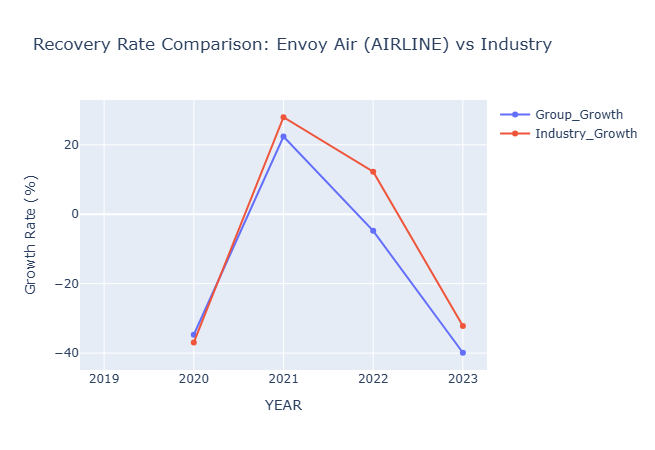

,YEAR,Group_Flights,Industry_Flights,Group_Growth,Industry_Growth
0,2019,22111,505345,NaN,NaN
1,2020,14435,318768,-34.72,-36.92
2,2021,17665,407824,22.38,27.94
3,2022,16823,457760,-4.77,12.24
4,2023,10111,310303,-39.90,-32.21


In [31]:
growth_analysis(df_flights, "AIRLINE", "Envoy Air")

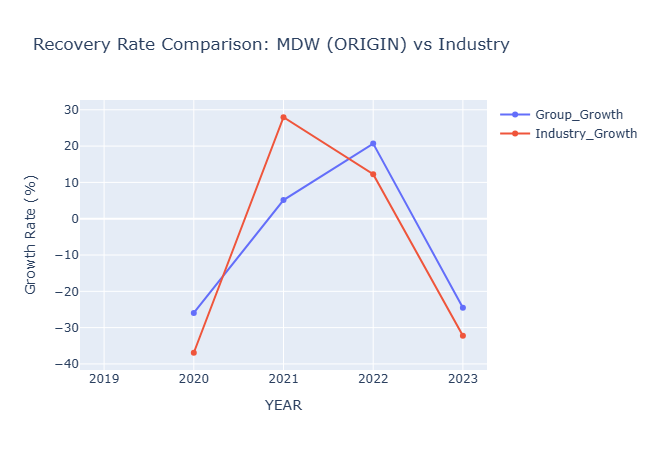

,YEAR,Group_Flights,Industry_Flights,Group_Growth,Industry_Growth
0,2019,5550,505345,NaN,NaN
1,2020,4110,318768,-25.95,-36.92
2,2021,4321,407824,5.13,27.94
3,2022,5215,457760,20.69,12.24
4,2023,3935,310303,-24.54,-32.21


In [32]:
growth_analysis(df_flights, "ORIGIN", "MDW")